In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
# import cudf # El DataFrame de RAPIDS, similar a pandas
# from cuml.manifold import UMAP as cumlUMAP
import numpy as np
import pandas as pd
from glob import glob
import os
import umap
from tqdm import tqdm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2025-07-15 00:31:50.060943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 00:31:50.061011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 00:31:50.061036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 00:31:50.069015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/users/cdonoso/miniconda3/lib/python3.11/site

In [3]:
model_path_0 = './presentation/results/diagstromer/2024-12-02_14-13-12/pretraining/'
# model_path_1 = './presentation/results/diagstromer/2024-12-02_14-13-12/finetuning/atlas/fold_0/atlas_500/'
model_path_1 = './presentation/results/diagstromer/2024-12-02_14-13-12/finetuning/alcock/fold_0/alcock_500/'
models = []
configs = []
for m in [model_path_0, model_path_1]:
    astromer, config = load_pt_model(m)
    models.append(astromer)
    configs.append(config)

label = ['Pretrained', 'Finetuned']

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


2025-07-15 00:31:55.130570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-15 00:31:55.130598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pececillo
2025-07-15 00:31:55.130603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pececillo
2025-07-15 00:31:55.130662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2025-07-15 00:31:55.130676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2025-07-15 00:31:55.130680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.104.5


[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


In [4]:
dsname = 'alcock'
data = './data/shared/records/{}/fold_0/{}/'.format(dsname, dsname)
# data = './data/shared/records/atlas/fold_0/atlas/'
batch_size = 64
loaders = build_loader(data, 
                       params=config,
                       batch_size=batch_size, 
                       sampling=False,
                       return_test=True,
                       shuffle=False,
                       probed=0.,
                       random=0.0,
                       same=0.0,
                       clf_mode=True,
                    )

metadata = pd.read_parquet('./data/raw_parquet/{}/metadata.parquet'.format(dsname))
metadata = metadata[metadata['Class'] != 'Dubious']
metadata['Class'].unique()

Classification Mode
[INFO] String based loader
[INFO] Changing path:  ./data/shared/records/alcock/fold_0/alcock/val
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Cache activated
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Cache activated


array(['LPV', 'Cep_0', 'RRab', 'RRc', 'EC', 'UNK', 'Cep_1'], dtype=object)

In [5]:
xinp, xtme, xmsk = [], [], []
labels_code = []
for x, y in loaders['test']:
    labels = np.argmax(y.numpy(), 1)
    labels_code.append(labels)
    xinp.append(x['input'].numpy())
    xtme.append(x['times'].numpy())
    xmsk.append(x['mask_in'].numpy())
xinp = np.concatenate(xinp, 0)
xtme = np.concatenate(xtme, 0)
xmsk = np.concatenate(xmsk, 0)
labels_code = np.concatenate(labels_code, 0)

In [7]:
labels_map = {}
for val in metadata['Class'].unique():
    m = metadata[metadata['Class'] == val]['Label']
    labels_map[m.iloc[0]] = val    
if dsname == 'atlas':
    labels_map = {3: 'Other', 1: 'DB', 0: 'CB', 4: 'Pulse', 2: 'Mira'}

In [8]:
selected = []
for unique in np.unique(labels_code):
    indices = np.where(labels_code == unique)
    indices = indices[0]
    np.random.shuffle(indices)
    selected.append(indices[:100])
selected = np.concatenate(selected, 0)
subset = {'input': xinp[selected], 'times': xtme[selected], 'mask_in': xmsk[selected]}
subset_labels = labels_code[selected]

In [9]:
class_names = [labels_map[l] for l in subset_labels]

In [10]:
%%time
embeddings = models[-1].get_layer('encoder')(subset, z_by_layer=True)

CPU times: user 1min 8s, sys: 1min 22s, total: 2min 30s
Wall time: 9.46 s


In [15]:
%%time
num_blocks = len(embeddings)
n_samples  = embeddings[0].shape[0]
n_steps    = embeddings[0].shape[1]
z_dim      = embeddings[0].shape[2]

z_mean = np.zeros([num_blocks, n_samples, z_dim])
z_ccat = np.zeros([num_blocks, n_samples, n_steps*z_dim])
z_max = np.zeros([num_blocks, n_samples, z_dim])
pbar = tqdm(range(num_blocks), desc="Standarizing Input")
for i in pbar:
    zcurr = embeddings[i].numpy()
    z_flatconcat = zcurr.reshape(n_samples, -1)
    z_flatmean   = np.mean(zcurr, axis=1)
    z_flatmax   = np.max(zcurr, axis=1)
    z_ccat[i] = StandardScaler().fit_transform(z_flatconcat)
    z_mean[i] = StandardScaler().fit_transform(z_flatmean)
    z_max[i] = StandardScaler().fit_transform(z_flatmax)
z_flatconcat.shape

Standarizing Input: 100%|███████████████████████████████████████████████| 6/6 [00:02<00:00,  2.83it/s]

CPU times: user 1.61 s, sys: 514 ms, total: 2.13 s
Wall time: 2.12 s


(600, 51200)

In [16]:
%%time
pbar = tqdm(range(num_blocks), desc="Computing Embeddings")
LIMIT = n_samples # n_samples
reduced_umap = np.zeros([num_blocks, LIMIT, 2])
reduced_tsne = np.zeros([num_blocks, LIMIT, 2])
MODE = 'max'
for i in pbar:
    if MODE == 'mean':
        zr = z_mean[i, :LIMIT]
    if MODE == 'concat':
        zr = z_ccat[i, :LIMIT]
    if MODE == 'max':
        zr = z_max[i, :LIMIT]
        
    pbar.set_description(f"Block {i+1}/{len(embeddings)}: (UMAP)")
    reducer_umap = umap.UMAP(
        n_neighbors=50,
        min_dist=0.25,
        n_components=2,
        metric='cosine',
        random_state=42,
        n_jobs=16
    )
    reduced_umap[i] = reducer_umap.fit_transform(zr)

    pbar.set_description(f"Block {i+1}/{len(embeddings)} (t-SNE)")
    reducer_tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        n_jobs=16)
    reduced_tsne[i] = reducer_tsne.fit_transform(zr)
    
pbar.set_description("¡Proceso completado!")
pbar.close()
if MODE == 'mean':
    np.save('./presentation/notebooks/backup/umap_mean_{}.npy'.format(dsname), reduced_umap)
    np.save('./presentation/notebooks/backup/tsne_mean_{}.npy'.format(dsname), reduced_tsne)

if MODE == 'concat':
    np.save('./presentation/notebooks/backup/umap_concat_{}.npy'.format(dsname), reduced_umap)
    np.save('./presentation/notebooks/backup/tsne_concat_{}.npy'.format(dsname), reduced_tsne)
    
if MODE == 'max':
    np.save('./presentation/notebooks/backup/umap_max_{}.npy'.format(dsname), reduced_umap)
    np.save('./presentation/notebooks/backup/tsne_max_{}.npy'.format(dsname), reduced_tsne)


Block 1/6: (UMAP):   0%|                                                        | 0/6 [00:00<?, ?it/s]/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Block 2/6: (UMAP):  17%|████████                                        | 1/6 [00:03<00:18,  3.78s/it]/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Block 3/6: (UMAP):  33%|████████████████                                | 2/6 [00:07<00:14,  3.61s/it]/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Block 4/6: (UMAP):  50%|████████████████████████                        | 3/6 [00:10<00:10,  3.62s/it]/home/users/cdonoso/miniconda3/lib

CPU times: user 30.4 s, sys: 17.6 s, total: 48.1 s
Wall time: 21.8 s


In [17]:
encoder = LabelEncoder()
categorical_vector = encoder.fit_transform(class_names)
unique_cls_name = np.unique(class_names)

In [45]:
%%time
files = glob(os.path.join('./presentation/notebooks/backup/', 'umap*alcock*'))
print(files)
modeln = np.zeros([len(files), 6])
coefss_ccat = np.zeros([len(files), 6])
coefss_mean = np.zeros([len(files), 6])
coefss_max  = np.zeros([len(files), 6])
for k, pfile in enumerate(files):
    X = np.load(pfile)
    print(X.shape)
    for i in range(6):
        if 'mean' in pfile:
            coefss_mean[k, i] = silhouette_score(normalize(z_mean[i]), categorical_vector, metric='cosine')
        if 'max' in pfile:
            coefss_max[k, i] = silhouette_score(normalize(z_max[i]), categorical_vector, metric='cosine')
        if 'concat' in pfile:
            coefss_ccat[k, i] = silhouette_score(normalize(z_ccat[i]), categorical_vector, metric='cosine')

['./presentation/notebooks/backup/umap_concat_alcock.npy', './presentation/notebooks/backup/umap_max_alcock.npy', './presentation/notebooks/backup/umap_mean_alcock.npy']
(6, 600, 2)
(6, 600, 2)
(6, 600, 2)
CPU times: user 3.77 s, sys: 229 ms, total: 4 s
Wall time: 4 s


In [48]:
coefss_ccat

array([[-0.02947743, -0.01061761, -0.00775142,  0.00217348,  0.00249083,
         0.00228916],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

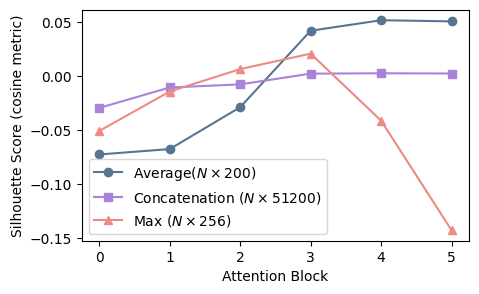

In [49]:
plt.figure(figsize=(5, 3))
xrange = np.arange(6)
plt.plot(xrange, coefss_mean[-1], marker='o', label=r'Average($N\times 200$)', color='#577590')
plt.plot(xrange, coefss_ccat[0], marker='s', label=r'Concatenation ($N\times 51200$)', color='#a983d8')
plt.plot(xrange, coefss_max[1], marker='^', label=r'Max ($N\times 256$)', color='#ec8a83')
plt.xlabel('Attention Block')
plt.ylabel('Silhouette Score (cosine metric)')
plt.legend()
plt.savefig('./presentation/figures/attention/silhuette_coeff.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [130]:
z_ccat[0].shape

(2590, 51200)

In [131]:

reduced_tsne = np.load('./presentation/notebooks/backup/tsne_mean.npy')
reduced_tsne.shape

(6, 2590, 2)

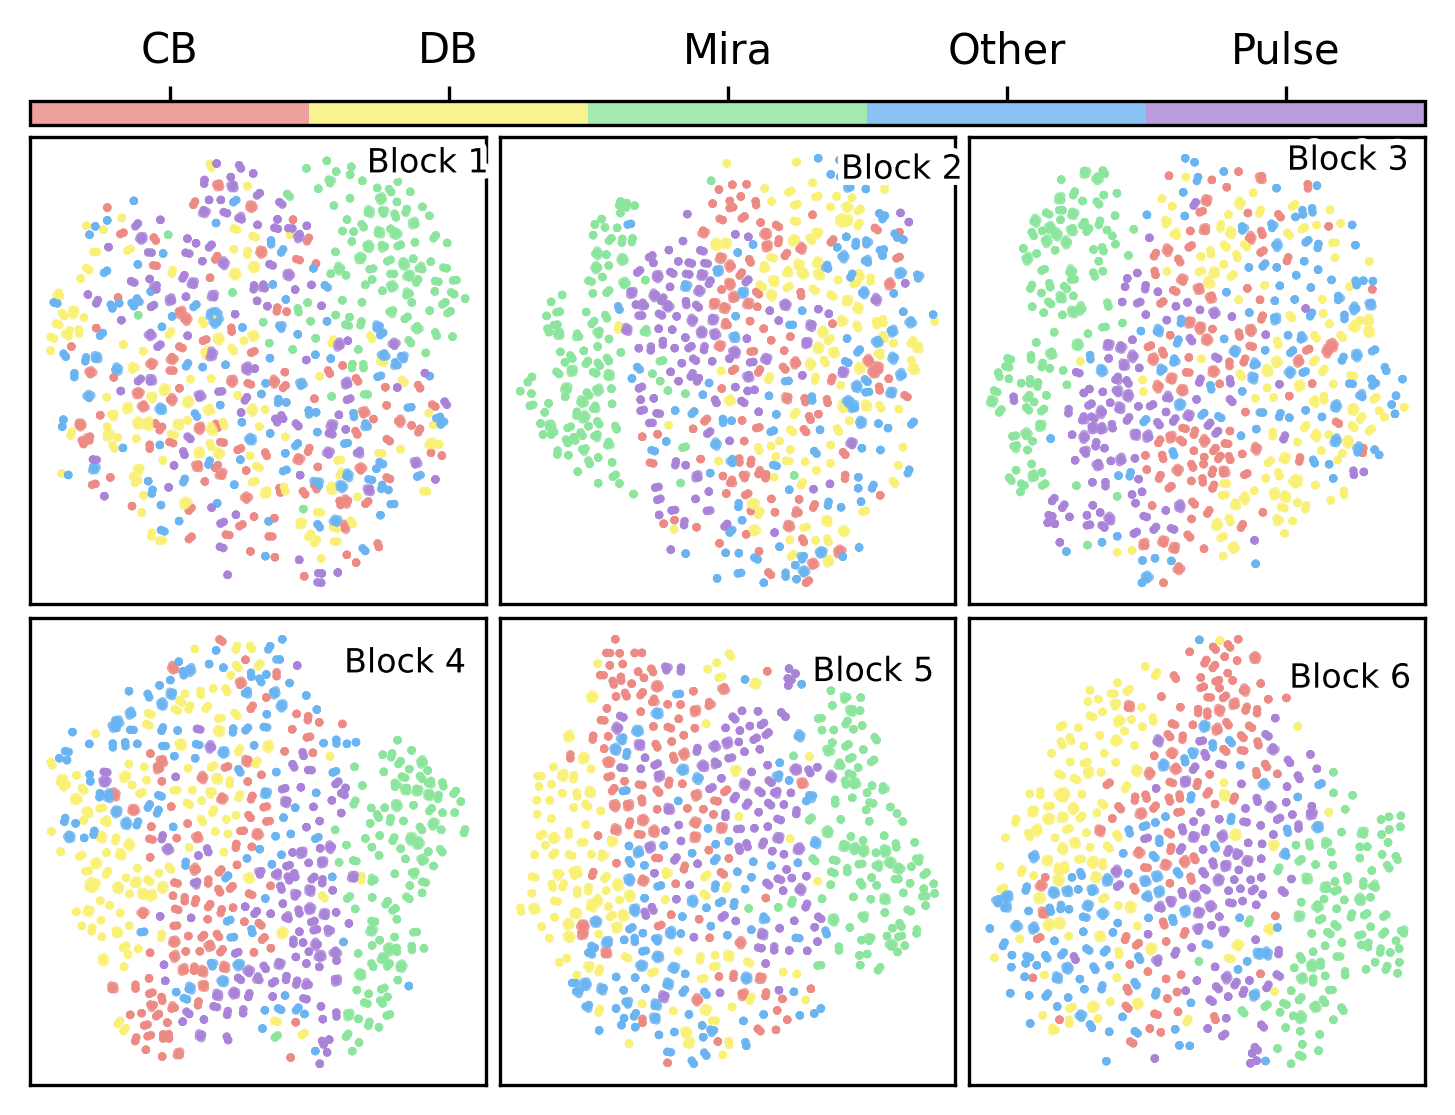

In [135]:
from matplotlib.colors import ListedColormap
from matplotlib.patheffects import withStroke

# cmap_colors = ['#ec8a83', '#f9f176', '#577590', '#8be59d', '#6ab4f1']
cmap_colors = ['#ec8a83', '#f9f176', '#577590', '#8be59d', '#6ab4f1', '#a983d8']
cmap = ListedColormap(cmap_colors)

fig, axes = plt.subplots(2, 3, figsize=(6, 4), sharex=False, sharey=False, dpi=300, 
                         gridspec_kw={'hspace':0.03,'wspace':0.03})
axes = axes.flatten()

scatter_objects =[]
d = 100
for i in range(6):    
    ax = axes[i].scatter(reduced_tsne[i][:, 0], 
                         reduced_tsne[i][:, 1], 
                         s=1, 
                         c=categorical_vector,
                         cmap=cmap, 
                         alpha=0.8, 
                         lw=1)
    axes[i].text(60, d, 'Block {}'.format(i+1),
                path_effects=[withStroke(linewidth=3, foreground='white')],fontsize=8)#'#dfe8eb'

    scatter_objects.append(ax)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Create the shared colorbar
fig.subplots_adjust(top=0.9)
boundaries = np.arange(len(unique_cls_name) + 1) - 0.5

cax = fig.add_axes([0.125, 0.91, 0.775, 0.02])
cbar = fig.colorbar(scatter_objects[0], cax=cax, ticks=np.arange(len(unique_cls_name)), 
                   boundaries=boundaries, orientation='horizontal')
cbar.ax.set_xticklabels(unique_cls_name)
cbar.ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# fig.savefig('./presentation/figures/attention/tsne_alcock.pdf', format='pdf', bbox_inches='tight')
# fig.savefig('./presentation/figures/attention/tsne_alcock.png', format='png', bbox_inches='tight')
fig.savefig('./presentation/figures/attention/tsne_atlas.pdf', format='pdf', bbox_inches='tight')
fig.savefig('./presentation/figures/attention/tsne_atlas.png', format='png', bbox_inches='tight')

# Visualizing Attention

In [183]:
from astropy.timeseries import LombScargle

def fold_curve(times, magnitudes):
    frequency, power = LombScargle(times, magnitudes).autopower()
    period = 1/frequency[np.argmax(power)]
    phase = (times % period)/period
    indices = np.argsort(phase)
    return indices

In [350]:
dsname = 'atlas'
data = './data/shared/records/{}/fold_0/{}_500/'.format(dsname, dsname)
# data = './data/shared/records/atlas/fold_0/atlas/'
batch_size = 64
loaders = build_loader(data, 
                       params=config,
                       batch_size=batch_size, 
                       sampling=True,
                       return_test=True,
                       shuffle=True,
                       probed=0.,
                       random=0.0,
                       same=0.0,
                       clf_mode=False,
                    )

metadata = pd.read_parquet('./data/raw_parquet/{}/metadata.parquet'.format(dsname))
metadata['Class'].unique()
metadata = metadata[metadata['Class'] != 'Dubious']

[INFO] String based loader
[INFO] Changing path:  ./data/shared/records/atlas/fold_0/atlas_500/val
[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated
[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Cache activated


In [351]:
%%time
batches_lc = []
batches_aw = []
batches_id = []
batches_times = []
batches_mask  = []
for x, y in loaders['train']:
    batches_id +=[item.decode('utf-8') for item in y['lcid'].numpy()]
    # ones = tf.one_hot(10, 200)
    # ones = tf.tile(tf.expand_dims(ones, 0), [x['mask_in'].shape[0], 1])
    # ones = tf.expand_dims(ones, -1)
    blockout = models[-1].get_layer('encoder')(x, return_weights=True, z_by_layer=True)
    batches_aw.append(blockout[1])
    batches_lc.append(x['input'])
    batches_times.append(x['times'])
    batches_mask.append(x['mask_in'])
    
batches_lc = np.concatenate(batches_lc, 0)
batches_aw = np.concatenate(batches_aw, 0)
batches_times = np.concatenate(batches_times, 0)
batches_mask = np.concatenate(batches_mask, 0)
batches_id = np.array(batches_id)

CPU times: user 5min 15s, sys: 20 s, total: 5min 35s
Wall time: 30.1 s


In [352]:
batches_lc.shape, batches_id.shape, batches_aw.shape, batches_times.shape, batches_mask.shape

((2000, 200, 1), (2000,), (2000, 4, 200, 200), (2000, 200, 1), (2000, 200, 1))

In [357]:
%%time
metadata['ID'] = metadata['ID'].astype(str)
labelclass = [metadata[metadata['ID'] == xid]['Class'].iloc[0] for xid in batches_id]

CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s


In [358]:
metadata['Class'].unique(), dsname

(array(['Other', 'DB', 'CB', 'Pulse', 'Mira'], dtype=object), 'atlas')

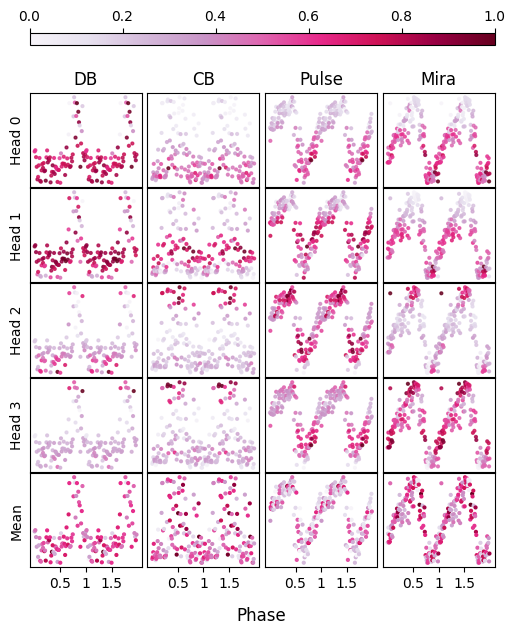

In [376]:
# rnd = metadata[(metadata['Class'] == 'CB') & (metadata['sset'] == 'train')].sample()['ID'].iloc[0]

indices = np.where(np.array(labelclass) == 'CB')
selecpartial = batches_id[indices[0]]
np.random.shuffle(selecpartial)
rnd = selecpartial[0]

if dsname == 'alcock':
    selected_id = ['23.3418.13', '82.8045.87', "1.3442.1107", "3.6967.450", "14.9587.18", "11.9838.37"]
    samples_ids = ['LPV', 'EC', 'RRab', 'RRc', 'Cep_0', 'CEP_1']
else:
    selected_id = ["84872811287900027", rnd, "71250902855801005", "96060192614903816"] #89310963544408025
    samples_ids = ['DB', 'CB', 'Pulse', 'Mira']


fig, axes = plt.subplots(5, len(selected_id), figsize=(6, 6), sharex=False, sharey=False, gridspec_kw={'hspace':0.01, 'wspace':0.05})


# for k in range(2):
for i, idx in enumerate(selected_id):

    axes[0][i].set_title(samples_ids[i])
        
    curr = pd.merge(metadata, pd.Series(batches_id, name='ID'), on='ID').sample()
    
    # idx = curr['ID'].iloc[0]
    index = np.where(batches_id==idx)[0][0]
    
    w = batches_aw[index]
    magnitudes = batches_lc[index][..., 0]
    times      = batches_times[index][..., 0]
    mask       =  batches_mask[index][..., 0]
    

    # just for visualization 
    p99 = np.percentile(magnitudes, q=95)
    p5 = np.percentile(magnitudes, q=5)
    times = times[(magnitudes > p5) & (magnitudes < p99)]
    mask  = mask[(magnitudes > p5) & (magnitudes < p99)]

    w = w[:, (magnitudes > p5) & (magnitudes < p99)]
    w = w[..., (magnitudes > p5) & (magnitudes < p99)]

    magnitudes = magnitudes[(magnitudes > p5) & (magnitudes < p99)]
    
    
    magnitudes = tf.boolean_mask(magnitudes, 1.-mask)
    times      = tf.boolean_mask(times, 1.-mask)
    
    w      = tf.boolean_mask(w, 1.-mask, axis=1)
    w      = tf.boolean_mask(w, 1.-mask, axis=2)
    indices = fold_curve(times, magnitudes)
    
    for k in range(w.shape[0]):
        currw = w[k]        
        currw = np.mean(currw, 0)
        currw = (currw - min(currw))/(max(currw) - min(currw))
        # currw = np.tile(currw, 2)

        ext_x = np.tile(np.array(magnitudes)[indices], [2])
        ext_w = np.tile(currw[indices], [2])
        ext_t = np.arange(len(ext_x))
        sc = axes[k][i].scatter(ext_t, ext_x, c=ext_w, s=4, alpha=0.8, cmap='PuRd')

        if i == 0:
            axes[k][i].set_ylabel('Head {}'.format(k), fontsize=10)
        
        axes[k][i].set_xticks([])
        axes[k][i].set_yticks([])
        # axes[k][i].set_xticklabels([0,  0.5, 1, 1.5, 2])
        
    currw = np.mean(w, 1)        
    currw = np.mean(currw, 0)
    currw = (currw - min(currw))/(max(currw) - min(currw))
    currw = np.tile(currw, 2) 

    sc = axes[k+1, i].scatter(np.arange(len(ext_x)), ext_x, c=currw, s=4, alpha=1., cmap='PuRd')
    axes[k+1, i].set_xticks([len(ext_x)/4, len(ext_x)/2, len(ext_x)/2+len(ext_x)/4])
    axes[k+1, i].set_xticklabels([0.5, 1, 1.5])
    if i == 0:
        axes[k+1][i].set_ylabel('Mean', fontsize=10)
    axes[k+1][i].set_yticks([])
fig.subplots_adjust(top=0.9)
cax = fig.add_axes([0.125, 0.98, 0.775, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Create the shared colorbar
#     cbar = fig.colorbar(sc, ax=axes, orientation='vertical', pad=0.01)
#     cbar.set_label('Normed Attention Value')

axes[2][1].set_xlabel('Phase', fontsize=12)
# axes[0][-1].set_title('Folded Mean', fontsize=12)
# fig.text(0.0, 0.5, 'Magnitude', va='center', rotation='vertical', fontsize=12)
fig.text(0.47, 0.03, 'Phase', va='center', rotation='horizontal', fontsize=12)
fig.savefig('./presentation/figures/attention/lightcurves_weights-{}.pdf'.format(dsname), format='pdf', bbox_inches='tight')

In [ ]:
for z, w, qkvalues in [blockout]:
    magnitudes = tf.boolean_mask(x['input'][N], 1.-x['mask_in'][N])
    times = tf.boolean_mask(x['times'][N], 1.-x['mask_in'][N])
    indices = fold_curve(times, magnitudes)

    fig, axes = plt.subplots(1, 5, figsize=(15, 2.5), sharex=True, sharey=True, gridspec_kw={'wspace':0.1})
    
    for i in range(w.shape[1]):
        currw = w[N, i]        
        currw = np.mean(currw, 0)
        currw = (currw - min(currw))/(max(currw) - min(currw))
        currw = np.tile(currw, 2)
        
        ext_x = np.tile(magnitudes.numpy()[indices], [2])
        ext_t = np.arange(len(ext_x))
        sc = axes[i].scatter(ext_t, ext_x, c=currw, s=4, alpha=0.8, cmap='seismic')
#         axes[i].text(340, -0.22, 'Head {}'.format(i))
        axes[i].set_title('Head {}'.format(i), fontsize=12)
        axes[i].set_xlabel('Phase', fontsize=12)
        axes[i].set_xticks([0, 100, 200, 300, 400])
        axes[i].set_xticklabels([0,  0.5, 1, 1.5, 2])
        
    currw = np.median(w[N], 1)        
    currw = np.median(currw, 0)
    currw = (currw - min(currw))/(max(currw) - min(currw))
    currw = np.tile(currw, 2)    
    sc = axes[-1].scatter(ext_t, ext_x, c=currw, s=4, alpha=1., cmap='seismic')

    # Create the shared colorbar
    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', pad=0.01)
    cbar.set_label('Normed Attention Value')
    axes[-1].set_xlabel('Phase', fontsize=12)
    axes[-1].set_title('Heads Median', fontsize=12)
    axes[0].set_ylabel('Magnitude', fontsize=12)
    
    # fig.savefig('./presentation/figures/attention/w_cepheid.pdf', format='pdf')
    # fig.savefig('./presentation/figures/attention/w_{}.pdf'.format(class_names[N]), format='pdf', bbox_inches='tight')


##### 

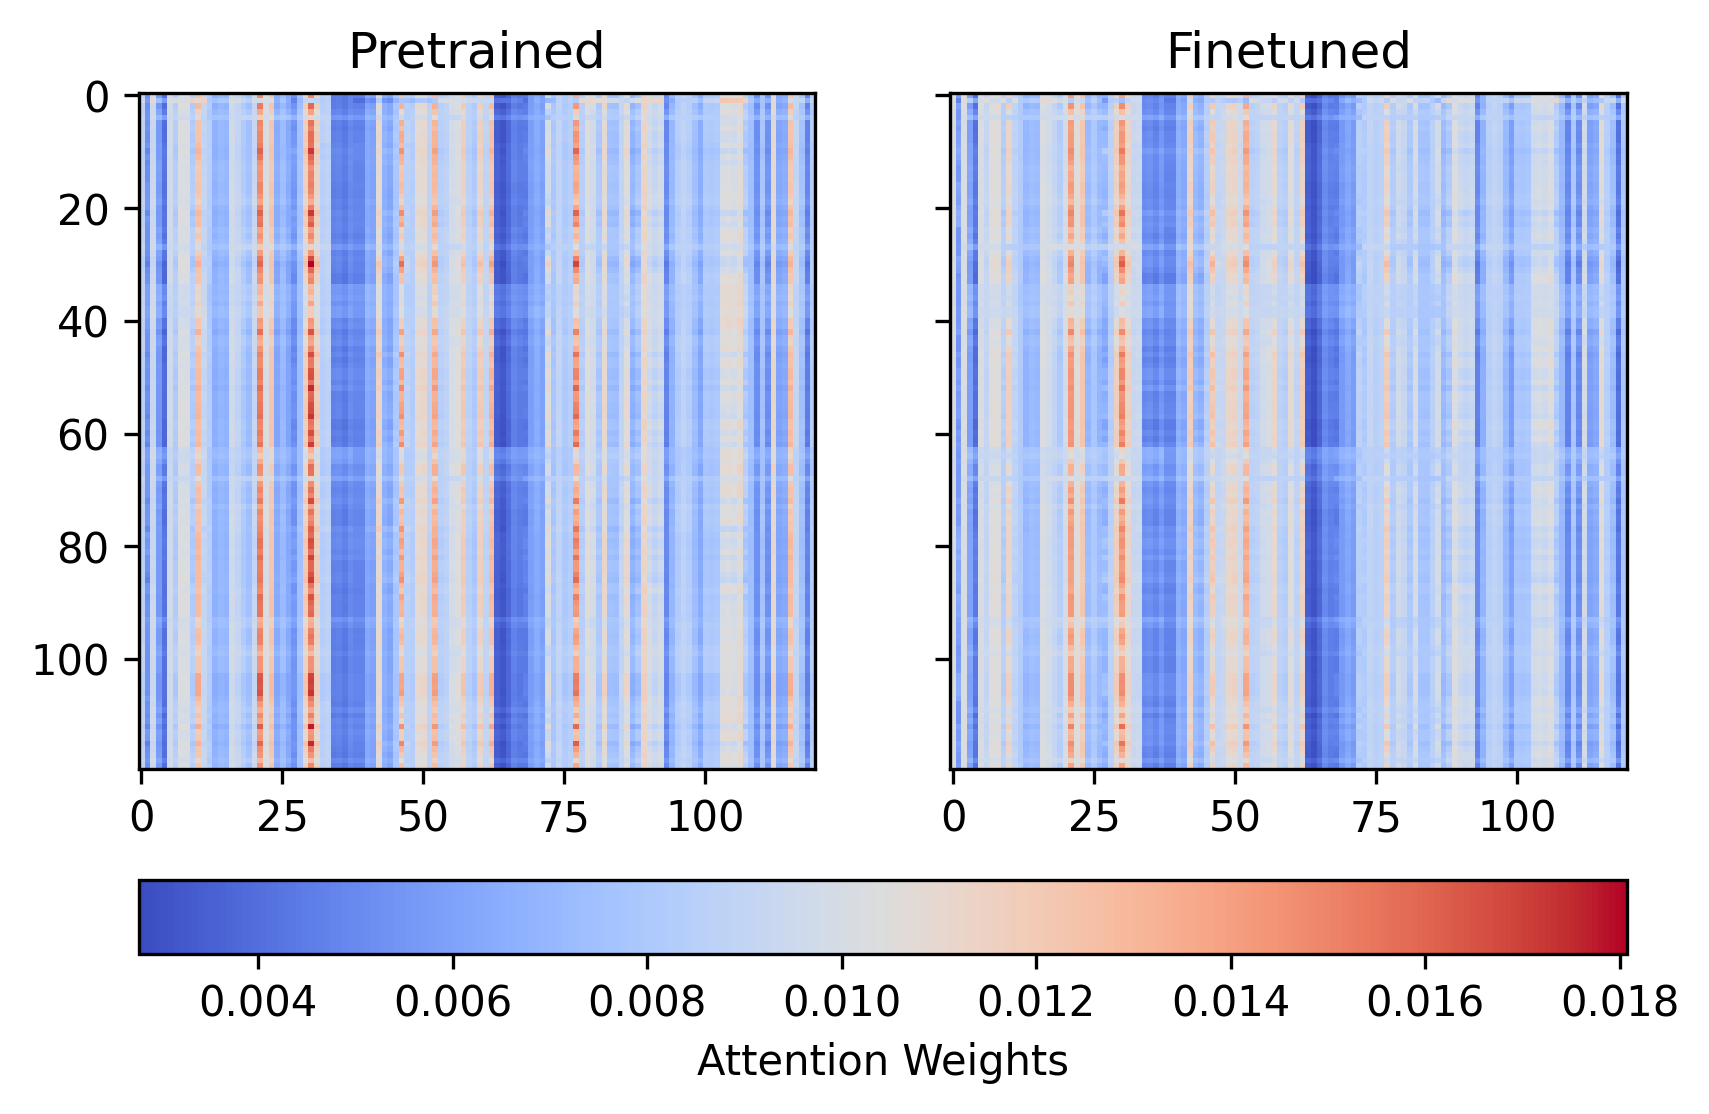

In [73]:
import matplotlib.colors as mcolors
import tensorflow as tf

# Assuming models and batch are defined previously
N = 1
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, dpi=300)

# Create a list to store the weight arrays for normalization
weights_list = []
# Loop over the models to plot
for i, m in enumerate(models):
    encoder = m.get_layer("encoder")
    z, w, qkvalues = encoder(batch, return_weights=True)
    
    light_curve  = batch['input'][N, :, 0].numpy()
    mask_in      = batch['mask_in'][N, :, 0].numpy()
    times        = batch['times'][N, :, 0].numpy()
    
    weights = tf.boolean_mask(w[N, 0], 1.-mask_in)
    weights = tf.boolean_mask(weights, 1.-mask_in, axis=1)
    
    weights_list.append(weights.numpy())  # Store weights for normalization
    axes[i].imshow(weights.numpy(), cmap='coolwarm')  # Adjust cmap as necessary

    axes[i].set_title(label[i])
# Normalize the color scale across both subplots
vmin = min(w.min() for w in weights_list)
vmax = max(w.max() for w in weights_list)

# Add colorbars
for i, ax in enumerate(axes):
    im = ax.imshow(weights_list[i], cmap='coolwarm', vmin=vmin, vmax=vmax)
    
# Add a shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.set_label('Attention Weights')  # Set the label for the colorbar

plt.show()


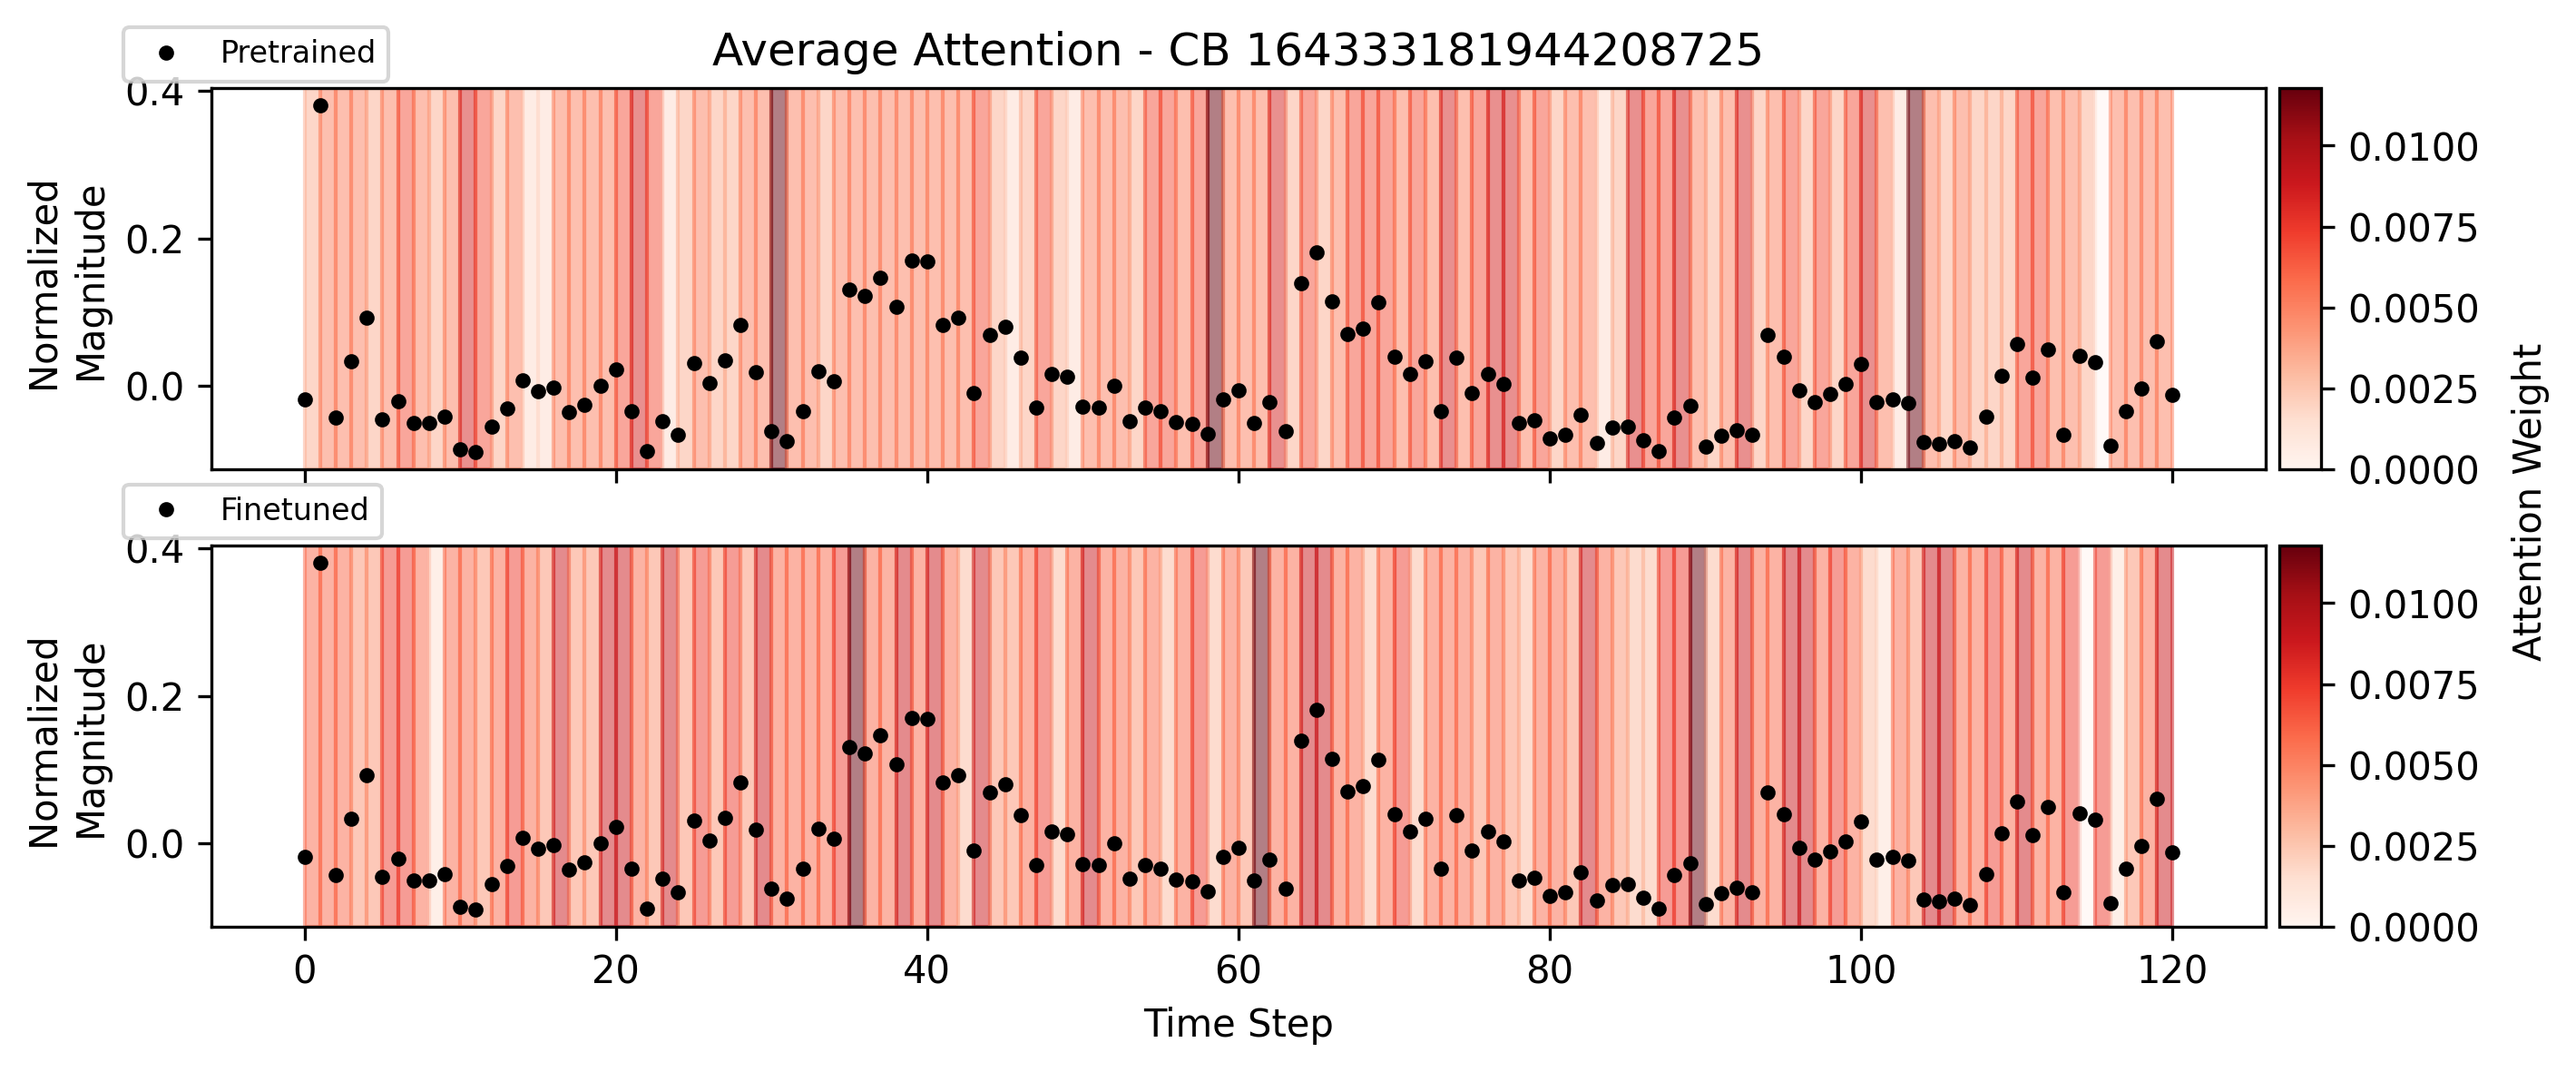

In [74]:
        
for m in models:
    encoder = m.get_layer("encoder")
    z, w, qkvalues = encoder(batch, return_weights=True)

    light_curve  = batch['input'][N, :, 0].numpy()
    mask_in      = batch['mask_in'][N, :, 0].numpy()
    times        = batch['times'][N, :, 0].numpy()
    
    att_weigths  = w[N].numpy()
    id_lc = batch_out['lcid'][N].numpy().decode()
    lc_metadata  = metadata[metadata['ID'].astype(str) == str(id_lc)]
    class_name   = lc_metadata['Class'].values[0]
    validindices = np.where(light_curve !=0)[0]
    light_curve  = light_curve[validindices]
    mask_in      = mask_in[validindices]
    times        = times[validindices]
    att_weigths  = att_weigths[:,validindices][..., validindices]

    indices = fold_curve(times, light_curve)

    magnitudes.append(light_curve)
    attentions.append(att_weigths)
    
min_values = []
max_values = []
LL = 10
head_n = -1
H = 4
for aw in attentions:
    mean_attention = aw[head_n]
    mean_attention = np.mean(mean_attention, 0)#np.mean(mean_attention, 0)
    max_values.append(mean_attention.max())
    min_values.append(mean_attention.min())

min_att = min(min_values)
max_att = min(max_values)

fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=300, sharex=True, sharey=True)
count = 0
for count in range(len(models)):
    aw = attentions[count]
    lc = magnitudes[count]

    mean_attention = aw[head_n]
    mean_attention = np.mean(mean_attention, -1)


    mean_attention = (mean_attention - mean_attention.min())/(mean_attention.max()-mean_attention.min())
    mean_attention = mean_attention*(max_att-min_att) + min_att
    sequence_length = lc.shape[0]


    # Normalize the attention values for better color scaling (0 to 1)
    norm = plt.Normalize(mean_attention.min(), mean_attention.max())
    axes[count].plot(range(sequence_length), lc, marker='.', linestyle='', color='k', label=label[count])
    
    # Choose a colormap (e.g., viridis, YlOrBr, Blues)
    cmap = plt.cm.Reds
    for i in range(sequence_length - 1):
        rgba_color = cmap(norm(mean_attention[i]))
        # ax.axvspan(times[i], times[i+1], color=rgba_color, alpha=0.5)
        axes[count].axvspan(i, i+1, color=rgba_color, alpha=0.5)
    
    # Add the color bar for attention values
    sm = ScalarMappable(cmap=cmap, norm=norm)  # ScalarMappable to link color mapping
    sm.set_array([])  # Required for color bar but not used directly in plotting

    axes[count].legend(loc='upper left', bbox_to_anchor=(-0.05, 1.2), fontsize=8)
    axes[count].set_ylabel('Normalized \nMagnitude')
    divider = make_axes_locatable(axes[count])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = plt.colorbar(sm, cax=cax)  # Add color bar to the same axis    
    count+=1

    

fig.text(0.97, 0.5, 'Attention Weight', va='center', rotation='vertical', fontsize=10)

axes[0].set_title('Average Attention - {} {}'.format(class_name, id_lc))
axes[1].set_xlabel('Time Step')

fig.savefig('./presentation/figures/attention/light_curve_att.pdf', bbox_inches='tight')

In [37]:
# plt.figure(dpi=200)
# plt.imshow(att_weigths[0], cmap='inferno')
# plt.title('Attention Weigths')
# plt.colorbar()
# plt.show()

## Getting Q, K, and V

In [67]:
encoder = models[0].get_layer('encoder')
config = configs[0]
for batch, _ in loaders['train'].take(1):
    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=batch_size)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=batch_size)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=batch_size)

    mask = batch['mask_in']

2024-12-05 02:13:45.341438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Effect of temperature

In [56]:
w = []
temps = [1, 2]#np.arange(0.5, 3, 0.5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.zeros_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [57]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, 10, :]
    attention_vectors.append(master)

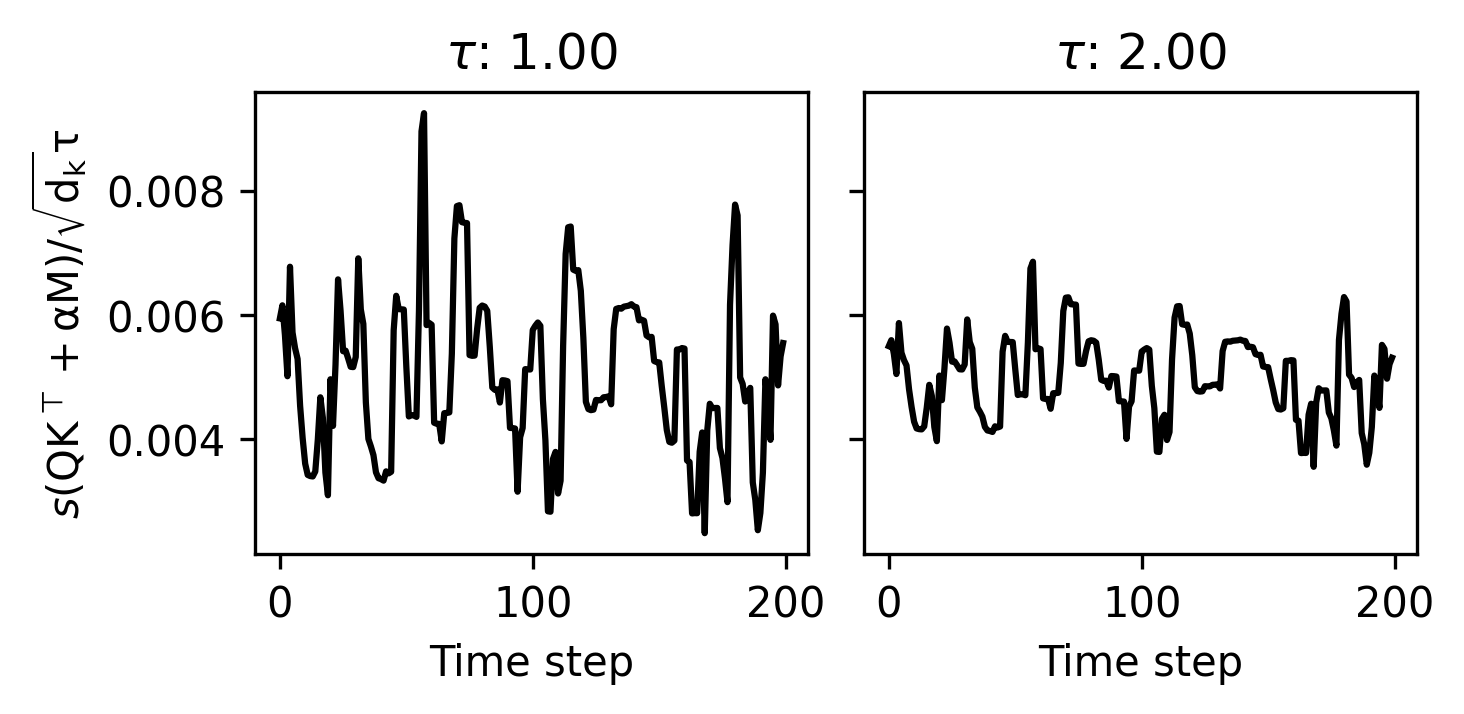

In [59]:
fig, axes = plt.subplots(1, len(temps), figsize=(5,2.), sharey=True, dpi=300, gridspec_kw={'wspace':0.1})

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title(r'$\tau$: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    # axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} +\alpha\rm{M})/\sqrt{d_k}\tau$')
fig.savefig('./presentation/figures/temperature.pdf', format='pdf', bbox_inches='tight')

### Effect of alpha when masking via softmax arg

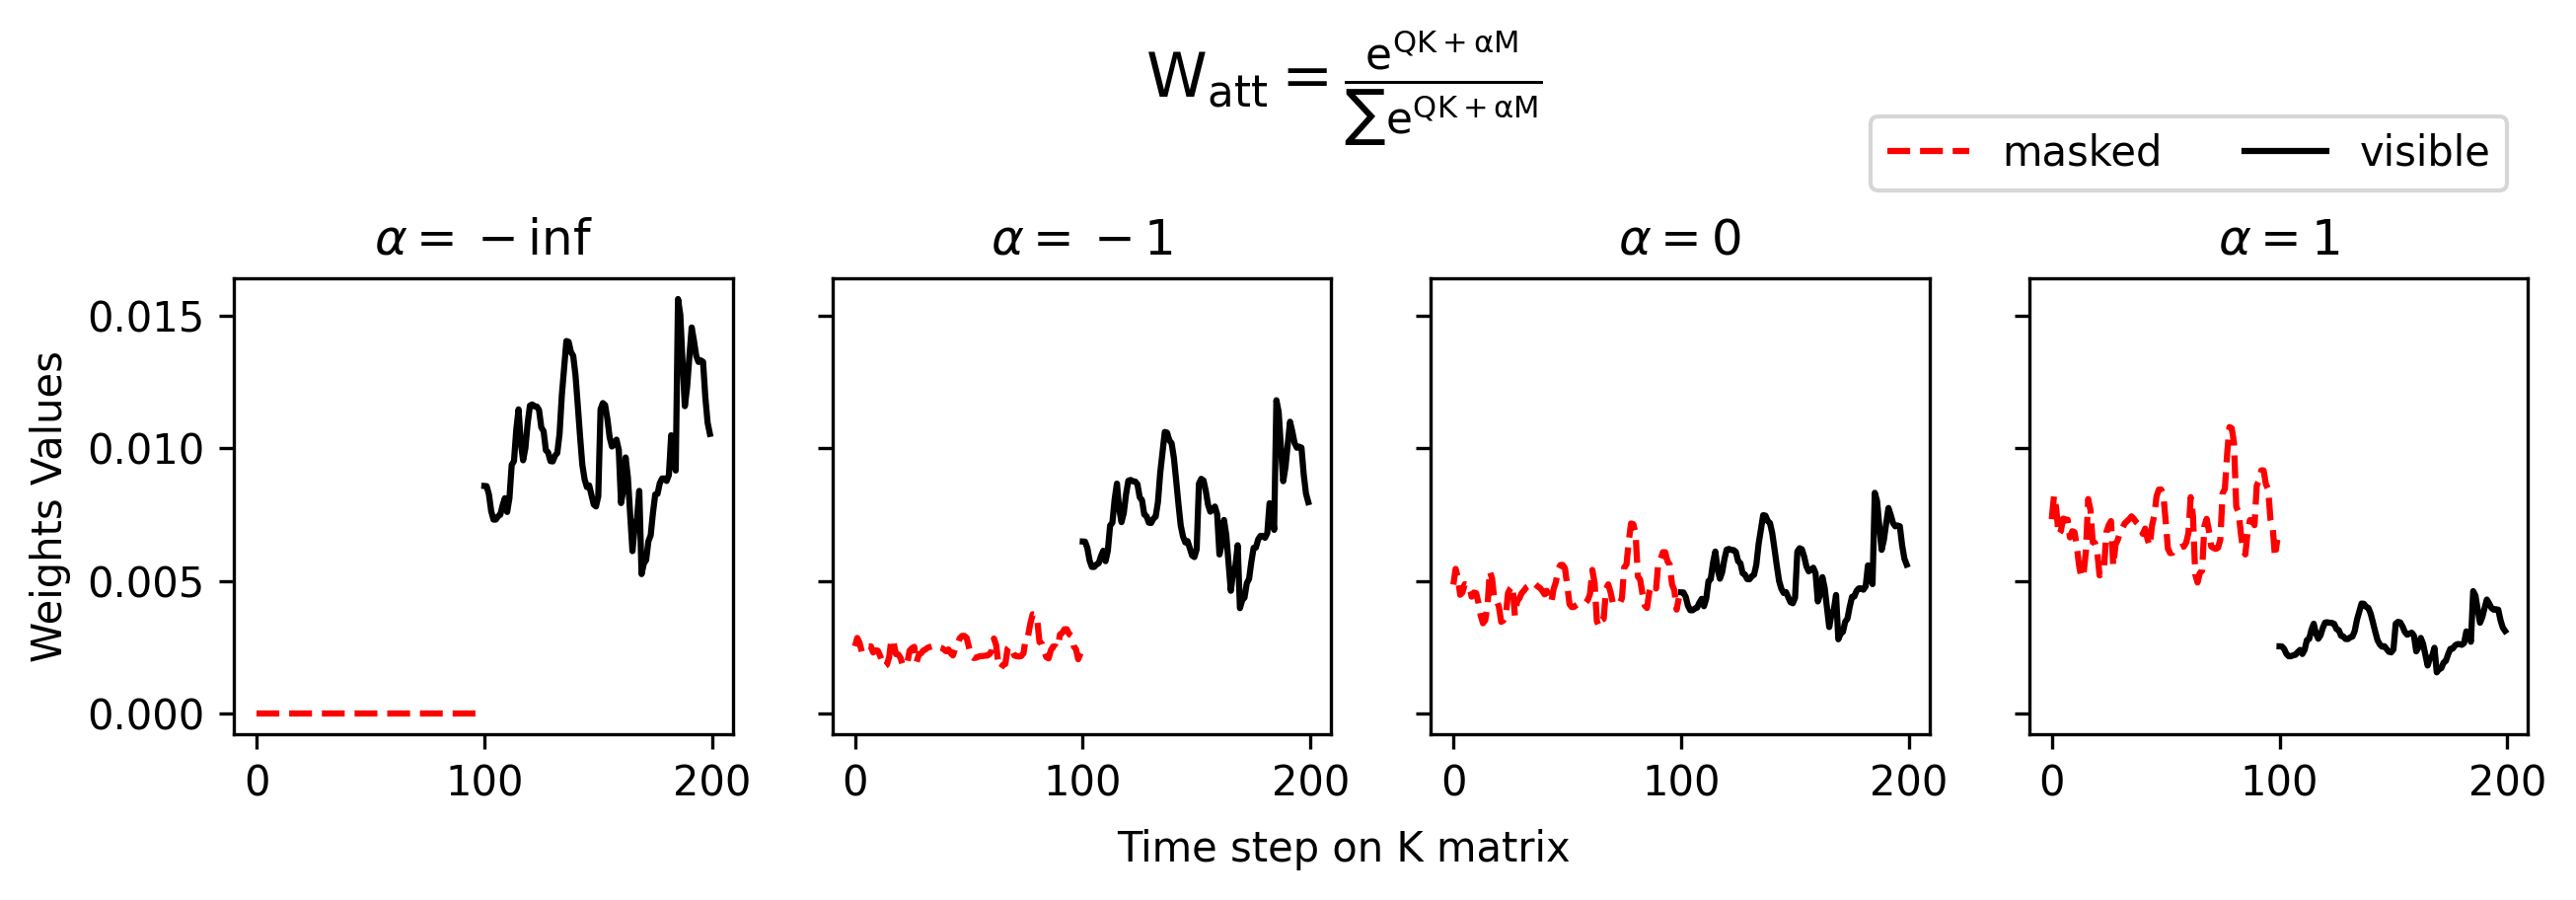

In [30]:
alphas = [-1e9, -1, 0, 1]
labels = [r'$\alpha=-\inf$', r'$\alpha=-1$', r'$\alpha=0$', r'$\alpha=1$']

fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):
    mask_dim = mask.shape
    neg = tf.ones([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    pos = tf.zeros([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    mask_new = tf.concat([neg, pos], 1)
    
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask_new, m_alpha=alp, mask_format='K')


    v = attention_weights[0, 0, 0]

    axes[i].plot(range(0, 100), v[:100], label='masked', color='red', linestyle='--')
    axes[i].plot(range(100, 200), v[100:200], label='visible', color='k')
    axes[i].set_title('{}'.format(labels[i]))
    # axes[i].set_yscale('log')
    # axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])

axes[-1].legend(bbox_to_anchor=(1., 1.4), ncols=2)
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.3,r'$\rm{W}_{att} = \frac{e^{QK + \alpha M}}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)
fig.text(0.5,-0.05,'Time step on K matrix',horizontalalignment='center',
       verticalalignment='top', fontsize=10)
fig.savefig('./presentation/figures/alpha_on_weights.pdf', format='pdf', bbox_inches='tight')
